# IMPORT STATMENTS FOR ALL MODLES

In [1]:
!TMPDIR=/home/mgill/ pip install --cache-dir=/home/mgill/ --build /home/mgill/ pandas numpy sklearn xgboost matplotlib tensorflow==2.1.0 keras==2.2.4 fastai python-dateutil scikit-optimize scikit-learn==0.21 seaborn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.regularizers import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from random import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation
from math import sqrt
from statistics import mean
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.impute import SimpleImputer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import GridSearchCV
import pickle
from collections import OrderedDict
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

2.1.0
2.2.4


Using TensorFlow backend.


In [3]:
def new_prep_data(tt_file, ho_file):
    imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
    my_list = []
    x = 0 
    for chunk in pd.read_csv(tt_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            tt_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(tt_pheno.shape)
            tt_pheno = np.reshape(tt_pheno,(len(tt_pheno),1))
            print(tt_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    tt_vcf = pd.concat(my_list, axis = 1)
    my_list = []
    x=0
    for chunk in pd.read_csv(ho_file, chunksize=10000, index_col="Unnamed: 0"):
        x=x+10000
        chunk = chunk.T
        if 'Value' in chunk.columns:
            #does the selecting of pheno array for application ML
            chunk["Value"] = pd.to_numeric(chunk["Value"], downcast="float")
            ho_pheno = chunk["Value"].to_numpy()
            #reshapes it so its not a 1D array
            print(ho_pheno.shape)
            ho_pheno = np.reshape(ho_pheno,(len(ho_pheno),1))
            print(ho_pheno.shape)
            chunk = chunk.drop(columns=['Value'])
        headers = chunk.columns
        row_idx = chunk.index
        chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
        #since imputing makes a numpy array have to turn back into PD for label encoding
        chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
        my_list.append(chunk)
        print(x)
    ho_vcf = pd.concat(my_list, axis = 1)
    print(tt_vcf.shape)
    print(ho_vcf.shape)
    return tt_vcf, ho_vcf, tt_pheno, ho_pheno

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("SeW_Merged_filtered.csv_train_test.csv_5pcnt.csv", "SeW_Merged_filtered.csv_holdout.csv_5pcnt.csv")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
(550,)
(550, 1)
230000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
(138,)
(138, 1)
230000
(550, 220590)
(138, 220590)


In [5]:
##Only run if it hasn't been already generated

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe = ohe.fit(tt_vcf)

(550, 220590)
(550, 636452)
(138, 220590)
(138, 636452)


In [6]:
pickle.dump(ohe, open("SeW_ohe.dat", "wb"))

In [5]:
#if need or have new holdout data etc.
ohe = pickle.load(open("SeW_ohe.dat", "rb"))

In [6]:
print(tt_vcf.shape)
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(550, 220590)
(550, 636452)
(138, 220590)
(138, 636452)


In [7]:
def find_snp_from_header(ohe,snp_num):
    count = 0
    snp = "Not found"
    found = False
    i = 0
    while i < len(ohe.categories_) and (found == False):
        j = 0
        while j < len(ohe.categories_[i]):
            if(count == snp_num):
                snp = ohe.categories_[i][j]
                found = True
                break
            count = count + 1
            j = j + 1
        i = i + 1
    return snp

In [8]:
## TESTING IF IT WORKS
my_snp = find_snp_from_header(ohe, 108005)
print(my_snp)

G/G


# XGBoost ML Model

In [10]:
print(tt_vcf.shape)
print(tt_pheno.shape)
seed = randint(0,5000)
X_train, X_test, y_train, y_test = train_test_split(tt_vcf, tt_pheno, test_size=0.2, random_state=seed)
print(X_test.shape)
print("seed is " + str(seed))

(550, 636452)
(550, 1)
(110, 636452)
seed is 1953


In [11]:
space ={'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(0, 50),
        'max_delta_step': Integer(0, 20),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-9, 1000, 'log-uniform'),
        'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'min_child_weight': Integer(0, 5),
        'n_estimators': Integer(50, 200),
        'scale_pos_weight': Real(1e-6, 500, 'log-uniform')}


In [12]:
def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = xgb_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

In [14]:
xgbreg = xgb.XGBRegressor()
xgb_bayes_search = BayesSearchCV(xgbreg, space, n_iter=32, # specify how many iterations
                                    scoring=None, n_jobs=1, cv=5, verbose=3, random_state=42, n_points=12,
                                 refit=True)
xgb_bayes_search.fit(X_train, y_train.ravel(), callback = on_step)
print(xgb_bayes_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.615, total= 2.2min
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.445, total= 2.1min
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.3min remaining:    0.0s


[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216, score=0.615, total= 2.1min
[CV] colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.05936070635912049, scale_pos_weight=0.060830282487222144, subsample=0.13556548021189216 
[CV]  colsample_bylevel=0.4160029192647807, colsample_bytree=0.7304484857455519, gamma=0.13031389926541354, learning_rate=0.042815319280763466, max_delta_step=13, max_depth=21, min_child_weight=2, n_estimators=161, reg_alpha=5.497557739289786e-07, reg_lambda=0.0593607063591

[CV]  colsample_bylevel=0.25617325301227906, colsample_bytree=0.7083937150495909, gamma=2.41812432168581e-07, learning_rate=0.13965555720269418, max_delta_step=10, max_depth=27, min_child_weight=1, n_estimators=76, reg_alpha=3.178148842971562e-08, reg_lambda=0.005381781269387993, scale_pos_weight=0.23835043249575294, subsample=0.9559763235078597, score=0.621, total= 1.3min
[CV] colsample_bylevel=0.7711308526006485, colsample_bytree=0.07988300914246868, gamma=1.3877597085692663e-08, learning_rate=0.15021004353467043, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=77, reg_alpha=0.006097622112520179, reg_lambda=1.9368851099909265e-09, scale_pos_weight=6.97020795804701e-06, subsample=0.46717487628832827 
[CV]  colsample_bylevel=0.7711308526006485, colsample_bytree=0.07988300914246868, gamma=1.3877597085692663e-08, learning_rate=0.15021004353467043, max_delta_step=6, max_depth=3, min_child_weight=3, n_estimators=77, reg_alpha=0.006097622112520179, reg_lambda=1.9368851099909

[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985, score=-35.659, total=  40.6s
[CV] colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, scale_pos_weight=0.4420166988445819, subsample=0.037978567417966985 
[CV]  colsample_bylevel=0.3569079180734289, colsample_bytree=0.1120289995668169, gamma=0.05034432042804318, learning_rate=0.7467518194835729, max_delta_step=7, max_depth=47, min_child_weight=1, n_estimators=67, reg_alpha=0.005500281359785164, reg_lambda=6.3166999939833564e-06, 

[CV]  colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868, score=0.428, total= 1.4min
[CV] colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.7439751766594195e-06, scale_pos_weight=1.6287615199535114e-06, subsample=0.9872483677632868 
[CV]  colsample_bylevel=0.19358622710388942, colsample_bytree=0.9236239290551462, gamma=6.242737149649543e-09, learning_rate=0.5839290998374393, max_delta_step=9, max_depth=2, min_child_weight=1, n_estimators=157, reg_alpha=0.32247446903004606, reg_lambda=5.74397517665941

[CV]  colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, scale_pos_weight=5.68219069233494e-06, subsample=0.3682037565911086, score=-1.342, total= 1.4min
[CV] colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, scale_pos_weight=5.68219069233494e-06, subsample=0.3682037565911086 
[CV]  colsample_bylevel=0.8477171831834894, colsample_bytree=0.9590782028716157, gamma=0.4419705200245942, learning_rate=0.010068534554171981, max_delta_step=18, max_depth=46, min_child_weight=5, n_estimators=66, reg_alpha=1.3396471230171212e-09, reg_lambda=0.1502689667792386, s

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 89.5min finished


best score: 0.6039091600599477
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] colsample_bylevel=0.13887674623178944, colsample_bytree=0.6294081393569894, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=37, min_child_weight=1, n_estimators=200, reg_alpha=0.07800695985936831, reg_lambda=1e-09, scale_pos_weight=173.38613484785495, subsample=0.01 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.13887674623178944, colsample_bytree=0.6294081393569894, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=37, min_child_weight=1, n_estimators=200, reg_alpha=0.07800695985936831, reg_lambda=1e-09, scale_pos_weight=173.38613484785495, subsample=0.01, score=0.153, total= 1.7min
[CV] colsample_bylevel=0.13887674623178944, colsample_bytree=0.6294081393569894, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=37, min_child_weight=1, n_estimators=200, reg_alpha=0.07800695985936831, reg_lambda=1e-09, scale_pos_weight=173.38613484785495, subsample=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV]  colsample_bylevel=0.13887674623178944, colsample_bytree=0.6294081393569894, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=37, min_child_weight=1, n_estimators=200, reg_alpha=0.07800695985936831, reg_lambda=1e-09, scale_pos_weight=173.38613484785495, subsample=0.01, score=-0.025, total= 1.7min
[CV] colsample_bylevel=0.13887674623178944, colsample_bytree=0.6294081393569894, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=37, min_child_weight=1, n_estimators=200, reg_alpha=0.07800695985936831, reg_lambda=1e-09, scale_pos_weight=173.38613484785495, subsample=0.01 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.4min remaining:    0.0s


[CV]  colsample_bylevel=0.13887674623178944, colsample_bytree=0.6294081393569894, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=37, min_child_weight=1, n_estimators=200, reg_alpha=0.07800695985936831, reg_lambda=1e-09, scale_pos_weight=173.38613484785495, subsample=0.01, score=0.079, total= 1.6min
[CV] colsample_bylevel=0.13887674623178944, colsample_bytree=0.6294081393569894, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=37, min_child_weight=1, n_estimators=200, reg_alpha=0.07800695985936831, reg_lambda=1e-09, scale_pos_weight=173.38613484785495, subsample=0.01 
[CV]  colsample_bylevel=0.13887674623178944, colsample_bytree=0.6294081393569894, gamma=1e-09, learning_rate=0.01, max_delta_step=20, max_depth=37, min_child_weight=1, n_estimators=200, reg_alpha=0.07800695985936831, reg_lambda=1e-09, scale_pos_weight=173.38613484785495, subsample=0.01, score=-0.294, total= 1.7min
[CV] colsample_bylevel=0.13887674623178944, colsample_bytree=0.6294081393569894, g

[CV]  colsample_bylevel=0.18192245762172138, colsample_bytree=0.9116712505759498, gamma=1.0302843796953239e-09, learning_rate=0.565022190803413, max_delta_step=10, max_depth=0, min_child_weight=1, n_estimators=159, reg_alpha=0.797587927985279, reg_lambda=1.2621776431168658e-06, scale_pos_weight=1e-06, subsample=1.0, score=-0.013, total= 1.1min
[CV] colsample_bylevel=0.18192245762172138, colsample_bytree=0.9116712505759498, gamma=1.0302843796953239e-09, learning_rate=0.565022190803413, max_delta_step=10, max_depth=0, min_child_weight=1, n_estimators=159, reg_alpha=0.797587927985279, reg_lambda=1.2621776431168658e-06, scale_pos_weight=1e-06, subsample=1.0 
[CV]  colsample_bylevel=0.18192245762172138, colsample_bytree=0.9116712505759498, gamma=1.0302843796953239e-09, learning_rate=0.565022190803413, max_delta_step=10, max_depth=0, min_child_weight=1, n_estimators=159, reg_alpha=0.797587927985279, reg_lambda=1.2621776431168658e-06, scale_pos_weight=1e-06, subsample=1.0, score=-0.007, total

[CV]  colsample_bylevel=0.024078980534285567, colsample_bytree=0.6300488108945057, gamma=1e-09, learning_rate=0.01001392093705502, max_delta_step=20, max_depth=36, min_child_weight=1, n_estimators=200, reg_alpha=0.9970207811098662, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=0.01, score=-0.278, total= 1.6min
[CV] colsample_bylevel=0.024078980534285567, colsample_bytree=0.6300488108945057, gamma=1e-09, learning_rate=0.01001392093705502, max_delta_step=20, max_depth=36, min_child_weight=1, n_estimators=200, reg_alpha=0.9970207811098662, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=0.01 
[CV]  colsample_bylevel=0.024078980534285567, colsample_bytree=0.6300488108945057, gamma=1e-09, learning_rate=0.01001392093705502, max_delta_step=20, max_depth=36, min_child_weight=1, n_estimators=200, reg_alpha=0.9970207811098662, reg_lambda=1e-09, scale_pos_weight=499.99999999999994, subsample=0.01, score=0.026, total= 1.6min
[CV] colsample_bylevel=1.0, colsample

[CV]  colsample_bylevel=0.5902671087499154, colsample_bytree=0.06111368383616246, gamma=7.0792712702246194e-09, learning_rate=0.01, max_delta_step=12, max_depth=4, min_child_weight=4, n_estimators=103, reg_alpha=1.435150976824627e-05, reg_lambda=640.7141618516714, scale_pos_weight=12.270657862919055, subsample=0.4467515254958122, score=-4.285, total=  48.9s
[CV] colsample_bylevel=0.5902671087499154, colsample_bytree=0.06111368383616246, gamma=7.0792712702246194e-09, learning_rate=0.01, max_delta_step=12, max_depth=4, min_child_weight=4, n_estimators=103, reg_alpha=1.435150976824627e-05, reg_lambda=640.7141618516714, scale_pos_weight=12.270657862919055, subsample=0.4467515254958122 
[CV]  colsample_bylevel=0.5902671087499154, colsample_bytree=0.06111368383616246, gamma=7.0792712702246194e-09, learning_rate=0.01, max_delta_step=12, max_depth=4, min_child_weight=4, n_estimators=103, reg_alpha=1.435150976824627e-05, reg_lambda=640.7141618516714, scale_pos_weight=12.270657862919055, subsamp

[CV]  colsample_bylevel=0.5815224146482153, colsample_bytree=0.3933226280229433, gamma=9.810380654192071e-07, learning_rate=0.018086249210884274, max_delta_step=9, max_depth=10, min_child_weight=4, n_estimators=118, reg_alpha=5.738257091143641e-05, reg_lambda=4.9085627805768315, scale_pos_weight=0.5361244780256605, subsample=0.44001883544524023, score=0.502, total= 1.4min
[CV] colsample_bylevel=0.5815224146482153, colsample_bytree=0.3933226280229433, gamma=9.810380654192071e-07, learning_rate=0.018086249210884274, max_delta_step=9, max_depth=10, min_child_weight=4, n_estimators=118, reg_alpha=5.738257091143641e-05, reg_lambda=4.9085627805768315, scale_pos_weight=0.5361244780256605, subsample=0.44001883544524023 
[CV]  colsample_bylevel=0.5815224146482153, colsample_bytree=0.3933226280229433, gamma=9.810380654192071e-07, learning_rate=0.018086249210884274, max_delta_step=9, max_depth=10, min_child_weight=4, n_estimators=118, reg_alpha=5.738257091143641e-05, reg_lambda=4.9085627805768315

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 85.6min finished


best score: 0.6154994566967451
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] colsample_bylevel=0.22889974921493345, colsample_bytree=0.806578438853149, gamma=9.001683065479833e-07, learning_rate=0.050895479317300006, max_delta_step=9, max_depth=20, min_child_weight=1, n_estimators=193, reg_alpha=0.0005674251490027294, reg_lambda=3.8383010566557046e-07, scale_pos_weight=0.09230416157347777, subsample=0.9488814086682058 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bylevel=0.22889974921493345, colsample_bytree=0.806578438853149, gamma=9.001683065479833e-07, learning_rate=0.050895479317300006, max_delta_step=9, max_depth=20, min_child_weight=1, n_estimators=193, reg_alpha=0.0005674251490027294, reg_lambda=3.8383010566557046e-07, scale_pos_weight=0.09230416157347777, subsample=0.9488814086682058, score=0.574, total= 3.0min
[CV] colsample_bylevel=0.22889974921493345, colsample_bytree=0.806578438853149, gamma=9.001683065479833e-07, learning_rate=0.050895479317300006, max_delta_step=9, max_depth=20, min_child_weight=1, n_estimators=193, reg_alpha=0.0005674251490027294, reg_lambda=3.8383010566557046e-07, scale_pos_weight=0.09230416157347777, subsample=0.9488814086682058 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s


[CV]  colsample_bylevel=0.22889974921493345, colsample_bytree=0.806578438853149, gamma=9.001683065479833e-07, learning_rate=0.050895479317300006, max_delta_step=9, max_depth=20, min_child_weight=1, n_estimators=193, reg_alpha=0.0005674251490027294, reg_lambda=3.8383010566557046e-07, scale_pos_weight=0.09230416157347777, subsample=0.9488814086682058, score=0.417, total= 3.2min
[CV] colsample_bylevel=0.22889974921493345, colsample_bytree=0.806578438853149, gamma=9.001683065479833e-07, learning_rate=0.050895479317300006, max_delta_step=9, max_depth=20, min_child_weight=1, n_estimators=193, reg_alpha=0.0005674251490027294, reg_lambda=3.8383010566557046e-07, scale_pos_weight=0.09230416157347777, subsample=0.9488814086682058 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.2min remaining:    0.0s


[CV]  colsample_bylevel=0.22889974921493345, colsample_bytree=0.806578438853149, gamma=9.001683065479833e-07, learning_rate=0.050895479317300006, max_delta_step=9, max_depth=20, min_child_weight=1, n_estimators=193, reg_alpha=0.0005674251490027294, reg_lambda=3.8383010566557046e-07, scale_pos_weight=0.09230416157347777, subsample=0.9488814086682058, score=0.529, total= 3.2min
[CV] colsample_bylevel=0.22889974921493345, colsample_bytree=0.806578438853149, gamma=9.001683065479833e-07, learning_rate=0.050895479317300006, max_delta_step=9, max_depth=20, min_child_weight=1, n_estimators=193, reg_alpha=0.0005674251490027294, reg_lambda=3.8383010566557046e-07, scale_pos_weight=0.09230416157347777, subsample=0.9488814086682058 
[CV]  colsample_bylevel=0.22889974921493345, colsample_bytree=0.806578438853149, gamma=9.001683065479833e-07, learning_rate=0.050895479317300006, max_delta_step=9, max_depth=20, min_child_weight=1, n_estimators=193, reg_alpha=0.0005674251490027294, reg_lambda=3.83830105

[CV]  colsample_bylevel=0.29027432340327297, colsample_bytree=0.43266750496361817, gamma=0.015375116212935443, learning_rate=0.5489934535454187, max_delta_step=3, max_depth=38, min_child_weight=2, n_estimators=89, reg_alpha=4.55971782960866e-07, reg_lambda=0.017163560135923888, scale_pos_weight=0.0011649112413479326, subsample=0.06703610303649603, score=-1.779, total=  56.2s
[CV] colsample_bylevel=0.8735440588779219, colsample_bytree=0.603635541380802, gamma=1.288089711387148e-09, learning_rate=0.026062701044777162, max_delta_step=8, max_depth=47, min_child_weight=3, n_estimators=129, reg_alpha=0.028144354682985734, reg_lambda=2.331116684735561e-09, scale_pos_weight=2.9296818458602494, subsample=0.8749661182625099 
[CV]  colsample_bylevel=0.8735440588779219, colsample_bytree=0.603635541380802, gamma=1.288089711387148e-09, learning_rate=0.026062701044777162, max_delta_step=8, max_depth=47, min_child_weight=3, n_estimators=129, reg_alpha=0.028144354682985734, reg_lambda=2.331116684735561

[CV]  colsample_bylevel=0.380930023211502, colsample_bytree=0.4942213307583409, gamma=2.026865070520627e-06, learning_rate=0.056617450433031416, max_delta_step=11, max_depth=21, min_child_weight=2, n_estimators=198, reg_alpha=2.3393558238786486e-05, reg_lambda=1.1742418644922257e-05, scale_pos_weight=12.006160700688502, subsample=0.6005343209977216, score=0.460, total= 3.9min
[CV] colsample_bylevel=0.380930023211502, colsample_bytree=0.4942213307583409, gamma=2.026865070520627e-06, learning_rate=0.056617450433031416, max_delta_step=11, max_depth=21, min_child_weight=2, n_estimators=198, reg_alpha=2.3393558238786486e-05, reg_lambda=1.1742418644922257e-05, scale_pos_weight=12.006160700688502, subsample=0.6005343209977216 
[CV]  colsample_bylevel=0.380930023211502, colsample_bytree=0.4942213307583409, gamma=2.026865070520627e-06, learning_rate=0.056617450433031416, max_delta_step=11, max_depth=21, min_child_weight=2, n_estimators=198, reg_alpha=2.3393558238786486e-05, reg_lambda=1.1742418

[CV]  colsample_bylevel=0.3028537097872889, colsample_bytree=0.607397820965505, gamma=2.5673121437988862e-05, learning_rate=0.04998120285102853, max_delta_step=12, max_depth=24, min_child_weight=2, n_estimators=164, reg_alpha=5.128802847940737e-06, reg_lambda=0.0027370748984369337, scale_pos_weight=1.1272447137266404, subsample=0.5447479186961147, score=0.616, total= 2.4min
[CV] colsample_bylevel=0.3028537097872889, colsample_bytree=0.607397820965505, gamma=2.5673121437988862e-05, learning_rate=0.04998120285102853, max_delta_step=12, max_depth=24, min_child_weight=2, n_estimators=164, reg_alpha=5.128802847940737e-06, reg_lambda=0.0027370748984369337, scale_pos_weight=1.1272447137266404, subsample=0.5447479186961147 
[CV]  colsample_bylevel=0.3028537097872889, colsample_bytree=0.607397820965505, gamma=2.5673121437988862e-05, learning_rate=0.04998120285102853, max_delta_step=12, max_depth=24, min_child_weight=2, n_estimators=164, reg_alpha=5.128802847940737e-06, reg_lambda=0.002737074898

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 102.5min finished


best score: 0.6154994566967451
OrderedDict([('colsample_bylevel', 0.8650309530749462), ('colsample_bytree', 0.16148185639606982), ('gamma', 0.08666499382155733), ('learning_rate', 0.10835893788852366), ('max_delta_step', 0), ('max_depth', 4), ('min_child_weight', 5), ('n_estimators', 200), ('reg_alpha', 8.930114541704433e-09), ('reg_lambda', 0.8738105952665401), ('scale_pos_weight', 13.097343728294895), ('subsample', 0.9294793836040448)])


In [15]:
xgb_bayes_search.best_params_

OrderedDict([('colsample_bylevel', 0.8650309530749462),
             ('colsample_bytree', 0.16148185639606982),
             ('gamma', 0.08666499382155733),
             ('learning_rate', 0.10835893788852366),
             ('max_delta_step', 0),
             ('max_depth', 4),
             ('min_child_weight', 5),
             ('n_estimators', 200),
             ('reg_alpha', 8.930114541704433e-09),
             ('reg_lambda', 0.8738105952665401),
             ('scale_pos_weight', 13.097343728294895),
             ('subsample', 0.9294793836040448)])

In [16]:
##START HERE

#xgbreg = xgb_bayes_search.best_estimator_ #xgb.XGBRegressor(#n_estimators=100, nthread=-1) 
xgbreg = xgb.XGBRegressor(**xgb_bayes_search.best_params_)

In [17]:
print(xgbreg)

XGBRegressor(base_score=None, booster=None,
             colsample_bylevel=0.8650309530749462, colsample_bynode=None,
             colsample_bytree=0.16148185639606982, gamma=0.08666499382155733,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.10835893788852366, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None,
             reg_alpha=8.930114541704433e-09, reg_lambda=0.8738105952665401,
             scale_pos_weight=13.097343728294895, subsample=0.9294793836040448,
             tree_method=None, validate_parameters=None, verbosity=None)


In [28]:
def eval_k_fold(m, x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = m
    i = 1
    for train,test in cv.split(x,y):
        #print(y[test])
        m.fit(x[train],y[train].ravel())
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [19]:
best_model = eval_k_fold(xgbreg, tt_vcf, tt_pheno, 10)

fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.032010616519114965
RMSE for dataset is:3.166820689688579& mean of this fold is 12.359635
this is 25.622282528725783% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.5474167833749659
RMSE for dataset is:2.6412338367550725& mean of this fold is 12.087274
this is 21.851361395955138% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.6467292939501239
RMSE for dataset is:2.3674809742921386& mean of this fold is 12.189089
this is 19.422952847250276% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.5069444724736774
RMSE for dataset is:2.7317019230551747& mean of this fold is 12.62091
this is 21.644255366426744% of the mean pheno data
fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.11981856336844121
RMSE for dataset is:3.1886111547971137&

In [20]:
all_preds = [x for x in best_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.54
RMSE of Holdout: 2.55
Mean of Holdout: 13.39
this is 19.030383787677923% of the mean pheno data


0 12.5 12.787599958181382
1 8.1 9.726000019311904
2 8.6 10.881000008583069
3 6.1 11.536499942541122
4 15.0 15.301999979019165
5 6.5 10.836000064611435


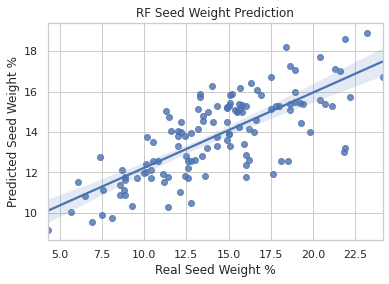

In [32]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()

for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Seed_Weight':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Seed_Weight", y="preds", data=thisplot)
plt.xlabel('Real Seed Weight %')
plt.ylabel('Predicted Seed Weight %')
plt.title("XGBoost Seed Weight Prediction")
plt.show()

In [22]:
pickle.dump(best_model, open("SeW_kfold_10_XGB.pickle.dat", "wb"))

In [9]:
#only load if not generated in same session
best_model = pickle.load(open("SeW_kfold_10_XGB.pickle.dat", "rb"))

<Figure size 1440x1440 with 0 Axes>

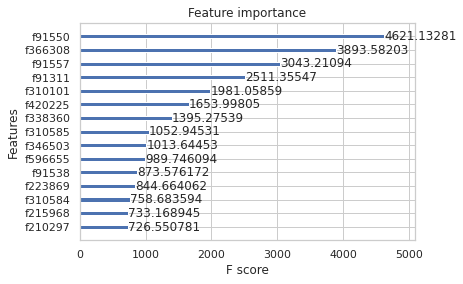

In [10]:
from xgboost import plot_importance
from matplotlib import pyplot
#best_model = pickle.load(open("Oil_kfold_10_tt_from_all.pickle.dat", "rb"))
plt.figure(figsize = (20, 20))
plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.3)
pyplot.show()

In [11]:
#This function essentially returns an array of dataframe headers the length of OHE'd input SNPs for training data
#EG. It will be able to determine that feature 357310 is Gm13_17683957 but not what allele it is
#eg. feature 357309 357310 and 357311 may all be one hot encoded versions of all possible values of Gm13_17683957
#iterating through the saved OHE will by able to determine what specific allele the feature is but cannot determine
#what SNP header it belongs to. Therefore combining these two methods you can determine both allele and SNP
snp = []
imp = SimpleImputer(missing_values='./.', strategy='most_frequent')
fs_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
x = 0
n_headers = []
le = LabelEncoder()
#while (i < 10):
for chunk in pd.read_csv("SeW_Merged_filtered.csv_train_test.csv_5pcnt.csv", chunksize=10000, index_col="Unnamed: 0"):
    chunk = chunk.T
    if 'Value' in chunk.columns:
        print("dropping value so it doesn't include that in headers")
        chunk = chunk.drop(columns=['Value'])
    headers = chunk.columns
    row_idx = chunk.index
    chunk = imp.fit_transform(chunk) #SHOULD TURN ./. into the most common for each column
    #since imputing makes a numpy array have to turn back into PD for label encoding
    chunk = pd.DataFrame(data = chunk, index = row_idx, columns = headers)
    chunk = chunk.apply(lambda col: le.fit_transform(col))
    c_headers = chunk.columns
    y = 0
    for column in chunk:
        d = (chunk[column].nunique())
        n_headers.extend([c_headers[y] for i in range(d)])
        #print(n_headers)
        #print(l)
        #n_headers.append(c_headers[y] * d)
        #print(n_headers)
        y = y + 1
    #to double check that it would indeed be one hot encoded with this amount of columns
    chunk = fs_ohe.fit_transform(chunk)
    x = x + chunk.shape[1]
    print("my X value is: " + str(x))
    print(chunk.shape)
    print("my header list is: " + str(len(n_headers)))
print(len(n_headers))

my X value is: 28304
(550, 28304)
my header list is: 28304
my X value is: 57038
(550, 28734)
my header list is: 57038
my X value is: 85973
(550, 28935)
my header list is: 85973
my X value is: 115096
(550, 29123)
my header list is: 115096
my X value is: 143521
(550, 28425)
my header list is: 143521
my X value is: 172592
(550, 29071)
my header list is: 172592
my X value is: 201816
(550, 29224)
my header list is: 201816
my X value is: 230663
(550, 28847)
my header list is: 230663
my X value is: 259274
(550, 28611)
my header list is: 259274
my X value is: 288151
(550, 28877)
my header list is: 288151
my X value is: 316838
(550, 28687)
my header list is: 316838
my X value is: 345639
(550, 28801)
my header list is: 345639
my X value is: 374366
(550, 28727)
my header list is: 374366
my X value is: 403191
(550, 28825)
my header list is: 403191
my X value is: 432292
(550, 29101)
my header list is: 432292
my X value is: 461487
(550, 29195)
my header list is: 461487
my X value is: 490447
(550, 28

In [ ]:
## OLD GRAPH with MANUAL ENTRY 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
fs = [593927,29855,588433,594046,588431,154384,89664,238306,29856,133635,212368,97360,310115,214640,238315]
scores = [3788.51,3012.53,2338.82,1817.61,1267.10,956.13,721.52,464.87,423.59,387.93,344.70,308.57,249.15,241.69,225.54]
snp_label = []
for jj in fs:
    jj_allele = find_snp_from_header(ohe, jj)
    this_snp = (n_headers[jj] + ' ('+str(jj_allele)+')')
    print(this_snp)
    snp_label.append(this_snp)
snp_label.reverse()
scores.reverse()
print(len(scores))
print(len(snp_label))
plt.barh(snp_label,scores)
plt.title('SNP Importance XGBoost Seed Oil')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

In [12]:
my_dict = best_model.get_booster().get_score(importance_type="gain")

In [13]:
def rename_f_header(fn,n_headers,ohe):
    fn = fn[1:]
    fn = int(fn)
    allele = find_snp_from_header(ohe, fn)
    this_snp = (n_headers[fn] + ' ('+str(allele)+')')
    return this_snp

In [14]:
#convert feature to actual SNP name
i = 0
new_dict = {}
for key in my_dict:
    new_key = rename_f_header(key, n_headers, ohe)
    new_dict[new_key] = my_dict[key]
    i = i + 1
    print(str(i))
    if(my_dict):
        continue
    else:
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [15]:
new_fi = pd.Series(new_dict)
print(new_fi)
df = new_fi.to_frame()
df = df.rename(columns = {0:'F_Score(GAIN)'})

Gm03_39166036 (T/T)    4621.132810
Gm19_40833976 (A/A)     170.774658
Gm06_9864130 (T/T)        5.669308
Gm05_25831259 (A/A)       0.505684
Gm11_4398517 (C/C)     1052.945310
                          ...     
Gm17_19826658 (C/T)       0.086915
Gm01_25857121 (A/G)       0.045018
Gm16_14353881 (G/A)       0.060025
Gm18_58345876 (T/T)       0.061427
Gm04_30841859 (T/G)       0.090471
Length: 1533, dtype: float64


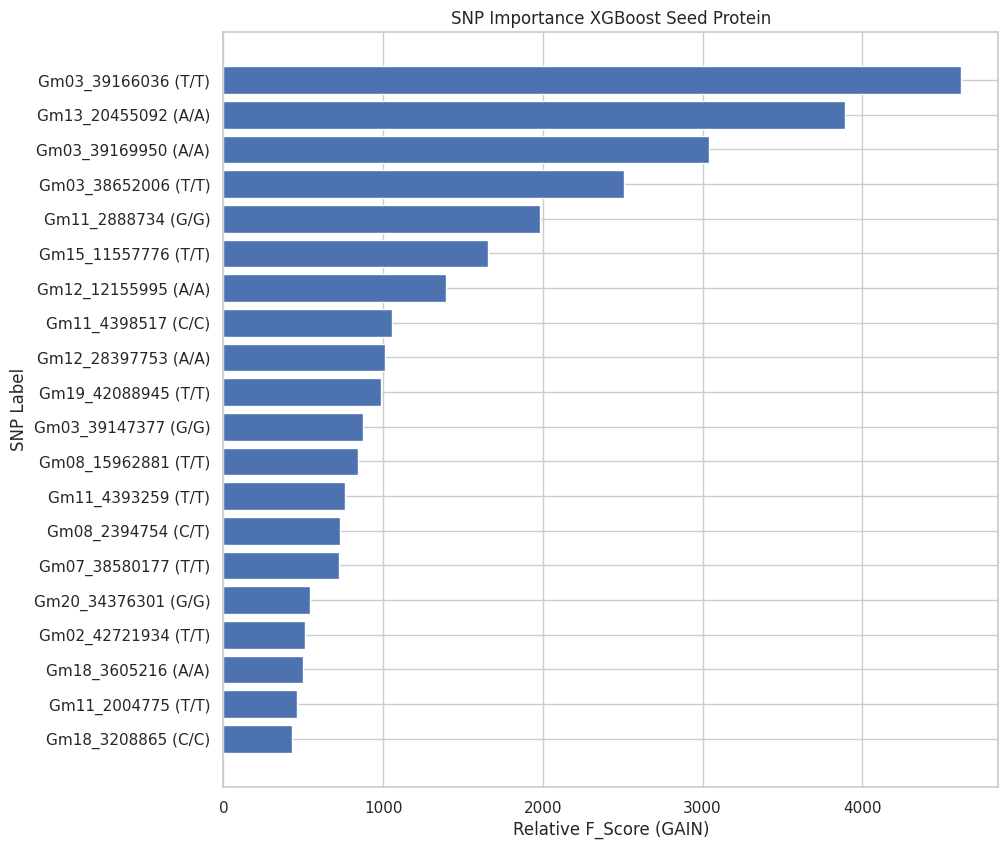

In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
plt.barh(indexes, values)
plt.title('SNP Importance XGBoost Seed Protein')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

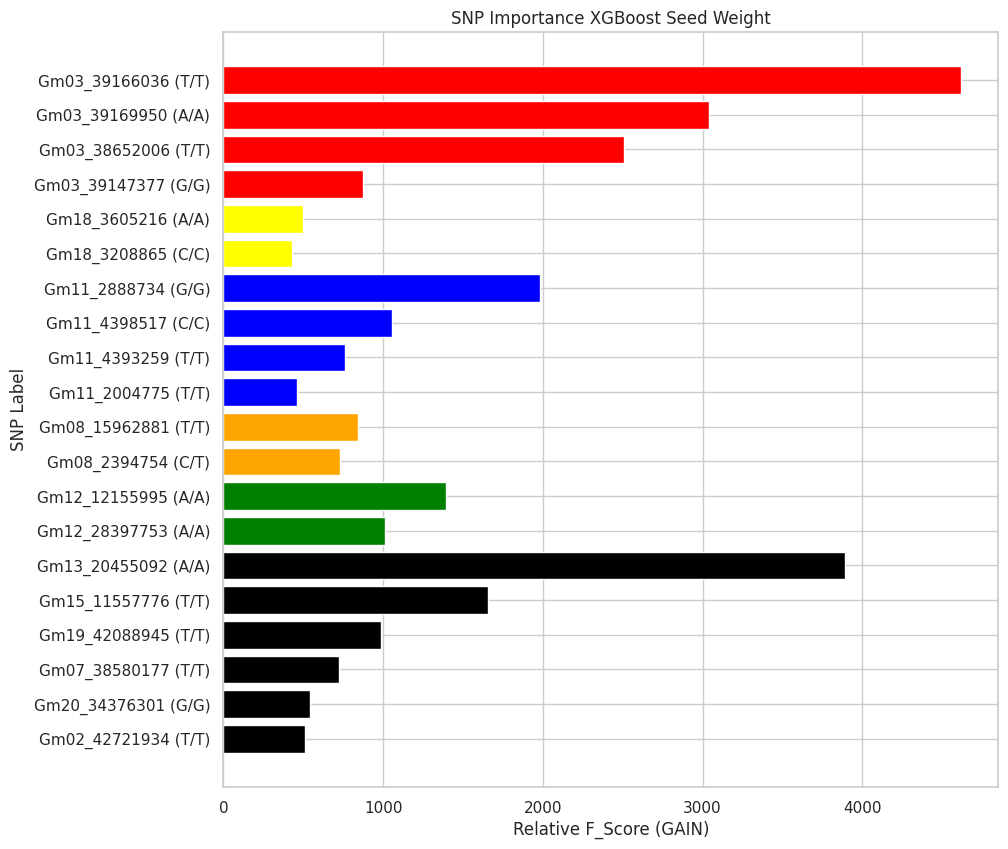

In [23]:
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
indexes = df.nlargest(20, "F_Score(GAIN)").index
values = df.nlargest(20, "F_Score(GAIN)").values.ravel()
indexes = indexes[::-1]
values = values[::-1]
r_i = []
r_v = []
b_i = []
b_v = []
g_i = []
g_v = []
y_i = []
y_v = []
bl_i = []
bl_v = []
p_i = []
p_v = []
i = 0
while i < len(indexes):
    if('Gm03' in indexes[i]):
        r_i.append(indexes[i])
        r_v.append(values[i])
    elif('Gm11' in indexes[i]):
        b_i.append(indexes[i])
        b_v.append(values[i])
    elif('Gm12' in indexes[i]):
        g_i.append(indexes[i])
        g_v.append(values[i])
    elif('Gm18' in indexes[i]):
        y_i.append(indexes[i])
        y_v.append(values[i])
    elif('Gm08' in indexes[i]):
        p_i.append(indexes[i])
        p_v.append(values[i])
    else:
        bl_i.append(indexes[i])
        bl_v.append(values[i])
    i = i + 1
plt.barh(bl_i, bl_v, color="black")
plt.barh(g_i, g_v, color="green")
plt.barh(p_i, p_v, color="orange")
plt.barh(b_i, b_v, color="blue")
plt.barh(y_i, y_v, color="yellow")
plt.barh(r_i, r_v, color="red")
plt.title('SNP Importance XGBoost Seed Weight')
plt.ylabel('SNP Label')
plt.xlabel('Relative F_Score (GAIN)')
plt.show()

# Random Forest Model

In [24]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data("SeW_Merged_filtered.csv_train_test.csv_5pcnt.csv", "SeW_Merged_filtered.csv_holdout.csv_5pcnt.csv")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
(550,)
(550, 1)
230000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
(138,)
(138, 1)
230000
(550, 220590)
(138, 220590)


In [25]:
ohe = pickle.load(open("SeW_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(550, 636452)
(138, 220590)
(138, 636452)


In [26]:
model = RandomForestRegressor(n_estimators=100, random_state=16, max_features = 'sqrt',n_jobs=-1, verbose = 1)
#trains the model, and makes the y shape as (m,) instead of (m,1)
#model.fit(X_train, y_train.ravel())

In [29]:
best_rf_model = eval_k_fold(model, tt_vcf, tt_pheno, 10)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


fitting done. Processing fold accuracy + checking best model


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


R^2 Value is: 0.27219523488951425
RMSE for dataset is:2.361247236182041& mean of this fold is 13.015453
this is 18.141874698863514% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


fitting done. Processing fold accuracy + checking best model


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


R^2 Value is: 0.3490088940216761
RMSE for dataset is:2.7509487592989896& mean of this fold is 12.6736355
this is 21.706074496422282% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


fitting done. Processing fold accuracy + checking best model


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


R^2 Value is: -0.3050518602429657
RMSE for dataset is:2.961225949161439& mean of this fold is 12.909089
this is 22.939077489311078% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


fitting done. Processing fold accuracy + checking best model


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


R^2 Value is: -0.9419514890041654
RMSE for dataset is:3.184276571295427& mean of this fold is 12.599092
this is 25.273858545690718% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


fitting done. Processing fold accuracy + checking best model


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


R^2 Value is: 0.08530079171838434
RMSE for dataset is:3.7801509665993858& mean of this fold is 11.711819
this is 32.27637880179225% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


fitting done. Processing fold accuracy + checking best model


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


R^2 Value is: -0.20216232680673896
RMSE for dataset is:3.6852151347026605& mean of this fold is 13.332729
this is 27.640365605841737% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


fitting done. Processing fold accuracy + checking best model


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


R^2 Value is: -0.2231667296005222
RMSE for dataset is:2.673124746355596& mean of this fold is 12.859998
this is 20.786354698196995% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


fitting done. Processing fold accuracy + checking best model


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


R^2 Value is: 0.41569415778142416
RMSE for dataset is:2.6393365743246813& mean of this fold is 12.714547
this is 20.75840013548491% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


fitting done. Processing fold accuracy + checking best model


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


R^2 Value is: -0.16894474752102728
RMSE for dataset is:2.7480559816297845& mean of this fold is 13.298727
this is 20.664052839714692% of the mean pheno data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


fitting done. Processing fold accuracy + checking best model
R^2 Value is: -0.3690546142745288
RMSE for dataset is:2.7041228063003784& mean of this fold is 12.770908
this is 21.174083557578157% of the mean pheno data
Training Testing Accuracy: 23.14% (3.96%)


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


In [30]:
all_preds = [x for x in best_rf_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.13
RMSE of Holdout: 2.90
Mean of Holdout: 13.39
this is 21.62909777168293% of the mean pheno data


[Parallel(n_jobs=28)]: Using backend ThreadingBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 100 out of 100 | elapsed:    0.0s finished


In [33]:
pickle.dump(best_rf_model, open("SeW_kfold_10_RF.pickle.dat", "wb"))


In [34]:
#only load if not generated in same session
best_rf_model = pickle.load(open("SeW_kfold_10_RF.pickle.dat", "rb"))

range(0, 138)


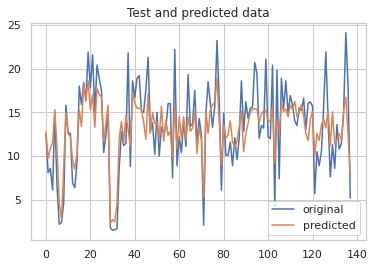

TypeError: list indices must be integers or slices, not range

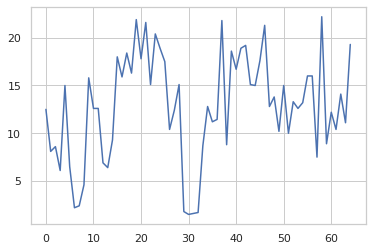

In [35]:
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="original")
plt.plot(x_ax, all_preds, label="predicted") 

plt.title("Test and predicted data")

plt.legend()
plt.show()

i = 0
interval = 65
while(i<len(ho_pheno)):
    i = i + interval
    if(i>len(ho_pheno)):
        my_range = range(i-interval,len(ho_pheno))
    else:
        my_range = range(i-interval,i)
    plt.plot(my_range, ho_pheno[my_range], label="original")
    plt.plot(my_range, all_preds[my_range], label="predicted") 

    plt.title("Test and predicted data")

    plt.legend()
    plt.show()

# CNN Model (Based upon DL Primer & GMStools)

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('SeW_Merged_filtered.csv_train_test.csv_5pcnt.csv', 'SeW_Merged_filtered.csv_holdout.csv_5pcnt.csv')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
(550,)
(550, 1)
230000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
(138,)
(138, 1)
230000
(550, 220590)
(138, 220590)


In [5]:
ohe = pickle.load(open("SeW_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(550, 636452)
(138, 220590)
(138, 636452)


In [6]:
def build_CNN_model(train_size):    
    #del model
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=14, 
                     input_shape=(train_size, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=10, kernel_size=10, 
                     input_shape=(12, 1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters=8, kernel_size=8, 
                     input_shape=(10, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(48, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax"


    model.compile(loss='mean_squared_error', optimizer=opt, 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    print(model.summary())
    return model

In [9]:
def eval_CNN(x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = []
    i = 1
    for train,test in cv.split(x,y):
        m = build_CNN_model(x.shape[1])
        print("Fold:" + str(i))
        x = x.reshape(x.shape[0], x.shape[1], 1)
        bs = ((x[train].shape[0])/50)
        bs = round(bs)
        m.fit(x[train],y[train].ravel(), validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
        del m
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [10]:
#my_model = build_CNN_model()
best_model = eval_CNN(tt_vcf, tt_pheno, 10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 636439, 12)        180       
_________________________________________________________________
activation_3 (Activation)    (None, 636439, 12)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 636439, 12)        0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 636430, 10)        1210      
_________________________________________________________________
activation_4 (Activation)    (None, 636430, 10)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 636430, 10)        0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 636423, 8)        

Epoch 33/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.9377 - root_mean_squared_error: 1.9844 - val_loss: 12.4138 - val_root_mean_squared_error: 3.5233
Epoch 34/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.9715 - root_mean_squared_error: 1.7238 - val_loss: 23.9866 - val_root_mean_squared_error: 4.8976
Epoch 35/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.8208 - root_mean_squared_error: 1.6795 - val_loss: 22.2996 - val_root_mean_squared_error: 4.7222
Epoch 36/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.9834 - root_mean_squared_error: 1.7273 - val_loss: 18.3164 - val_root_mean_squared_error: 4.2798
Epoch 37/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.8935 - root_mean_squared_error: 1.7010 - val_loss: 16.5093 - val_root_mean_squared_error: 4.0632
Epoch 38/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.7003 - root_mean_squared_erro

495/495 [==============================] - 7s 14ms/sample - loss: 2.0348 - root_mean_squared_error: 1.4265 - val_loss: 9.0784 - val_root_mean_squared_error: 3.0130
Epoch 80/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.6333 - root_mean_squared_error: 1.6227 - val_loss: 8.2960 - val_root_mean_squared_error: 2.8803
Epoch 81/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.8373 - root_mean_squared_error: 1.6844 - val_loss: 19.8248 - val_root_mean_squared_error: 4.4525
Epoch 82/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.8559 - root_mean_squared_error: 1.6899 - val_loss: 7.7069 - val_root_mean_squared_error: 2.7761
Epoch 83/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.1747 - root_mean_squared_error: 1.4747 - val_loss: 8.5478 - val_root_mean_squared_error: 2.9237
Epoch 84/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.0168 - root_mean_squared_error: 1.7369 - val_l

495/495 [==============================] - 7s 14ms/sample - loss: 2.9192 - root_mean_squared_error: 1.7086 - val_loss: 9.4874 - val_root_mean_squared_error: 3.0802
Epoch 56/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.2826 - root_mean_squared_error: 1.5108 - val_loss: 19.3496 - val_root_mean_squared_error: 4.3988
Epoch 57/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.2309 - root_mean_squared_error: 1.4936 - val_loss: 10.2492 - val_root_mean_squared_error: 3.2014
Epoch 58/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.5104 - root_mean_squared_error: 1.5844 - val_loss: 10.7420 - val_root_mean_squared_error: 3.2775
Epoch 59/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.0505 - root_mean_squared_error: 1.7466 - val_loss: 8.7386 - val_root_mean_squared_error: 2.9561
Epoch 60/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.6682 - root_mean_squared_error: 1.6335 - val

R^2 Value is: 0.4887170543965388
RMSE for dataset is:3.1894329418471163& mean of this fold is 12.568182
this is 25.377042948491574% of the mean pheno data
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 636439, 12)        180       
_________________________________________________________________
activation_9 (Activation)    (None, 636439, 12)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 636439, 12)        0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 636430, 10)        1210      
_________________________________________________________________
activation_10 (Activation)   (None, 636430, 10)        0         
_________________________________________________________________
dropout_7 (Dropout)          (N

Epoch 32/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.9439 - root_mean_squared_error: 1.7158 - val_loss: 8.2585 - val_root_mean_squared_error: 2.8738
Epoch 33/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.1513 - root_mean_squared_error: 1.7752 - val_loss: 10.9119 - val_root_mean_squared_error: 3.3033
Epoch 34/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.5223 - root_mean_squared_error: 1.8768 - val_loss: 8.2384 - val_root_mean_squared_error: 2.8703
Epoch 35/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.3406 - root_mean_squared_error: 1.8277 - val_loss: 10.4803 - val_root_mean_squared_error: 3.2373
Epoch 36/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.0043 - root_mean_squared_error: 1.7333 - val_loss: 12.7771 - val_root_mean_squared_error: 3.5745
Epoch 37/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.8200 - root_mean_squared_error:

495/495 [==============================] - 7s 14ms/sample - loss: 2.3439 - root_mean_squared_error: 1.5310 - val_loss: 14.1860 - val_root_mean_squared_error: 3.7664
Epoch 79/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.9087 - root_mean_squared_error: 1.7055 - val_loss: 15.4241 - val_root_mean_squared_error: 3.9274
Epoch 80/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.5021 - root_mean_squared_error: 1.8714 - val_loss: 8.3453 - val_root_mean_squared_error: 2.8888
Epoch 81/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.6379 - root_mean_squared_error: 1.6242 - val_loss: 6.4263 - val_root_mean_squared_error: 2.5350
Epoch 82/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.7193 - root_mean_squared_error: 1.6490 - val_loss: 12.9990 - val_root_mean_squared_error: 3.6054
Epoch 83/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.0321 - root_mean_squared_error: 1.7413 - val

495/495 [==============================] - 7s 14ms/sample - loss: 3.1657 - root_mean_squared_error: 1.7793 - val_loss: 12.7942 - val_root_mean_squared_error: 3.5769
Epoch 55/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.0513 - root_mean_squared_error: 1.7468 - val_loss: 5.9420 - val_root_mean_squared_error: 2.4376
Epoch 56/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.6106 - root_mean_squared_error: 1.9002 - val_loss: 5.6231 - val_root_mean_squared_error: 2.3713
Epoch 57/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.5965 - root_mean_squared_error: 1.6114 - val_loss: 8.5950 - val_root_mean_squared_error: 2.9317
Epoch 58/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.6804 - root_mean_squared_error: 1.6372 - val_loss: 6.2364 - val_root_mean_squared_error: 2.4973
Epoch 59/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.5079 - root_mean_squared_error: 1.8729 - val_l

Epoch 31/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.1005 - root_mean_squared_error: 1.7608 - val_loss: 6.6739 - val_root_mean_squared_error: 2.5834
Epoch 32/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.8704 - root_mean_squared_error: 1.6942 - val_loss: 5.9740 - val_root_mean_squared_error: 2.4442
Epoch 33/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.4533 - root_mean_squared_error: 1.5663 - val_loss: 7.1363 - val_root_mean_squared_error: 2.6714
Epoch 34/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.2060 - root_mean_squared_error: 1.7905 - val_loss: 5.6442 - val_root_mean_squared_error: 2.3758
Epoch 35/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.9104 - root_mean_squared_error: 1.7060 - val_loss: 6.3283 - val_root_mean_squared_error: 2.5156
Epoch 36/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.4886 - root_mean_squared_error: 1.

Epoch 8/100
495/495 [==============================] - 7s 14ms/sample - loss: 9.2791 - root_mean_squared_error: 3.0462 - val_loss: 157.4710 - val_root_mean_squared_error: 12.5487
Epoch 9/100
495/495 [==============================] - 7s 14ms/sample - loss: 6.1009 - root_mean_squared_error: 2.4700 - val_loss: 11.2839 - val_root_mean_squared_error: 3.3592
Epoch 10/100
495/495 [==============================] - 7s 14ms/sample - loss: 4.1431 - root_mean_squared_error: 2.0355 - val_loss: 7.0992 - val_root_mean_squared_error: 2.6644
Epoch 11/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.2205 - root_mean_squared_error: 1.7946 - val_loss: 8.7929 - val_root_mean_squared_error: 2.9653
Epoch 12/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.4315 - root_mean_squared_error: 1.8524 - val_loss: 7.8473 - val_root_mean_squared_error: 2.8013
Epoch 13/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.6543 - root_mean_squared_error: 

495/495 [==============================] - 7s 14ms/sample - loss: 2.5784 - root_mean_squared_error: 1.6057 - val_loss: 7.0666 - val_root_mean_squared_error: 2.6583
Epoch 55/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.1475 - root_mean_squared_error: 1.4654 - val_loss: 10.8049 - val_root_mean_squared_error: 3.2871
Epoch 56/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.2202 - root_mean_squared_error: 1.7945 - val_loss: 21.5475 - val_root_mean_squared_error: 4.6419
Epoch 57/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.7374 - root_mean_squared_error: 1.6545 - val_loss: 20.8295 - val_root_mean_squared_error: 4.5639
Epoch 58/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.7368 - root_mean_squared_error: 1.6543 - val_loss: 7.3604 - val_root_mean_squared_error: 2.7130
Epoch 59/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.2313 - root_mean_squared_error: 1.7976 - val

Epoch 31/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.9468 - root_mean_squared_error: 1.7166 - val_loss: 7.7368 - val_root_mean_squared_error: 2.7815
Epoch 32/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.9787 - root_mean_squared_error: 1.7259 - val_loss: 13.5501 - val_root_mean_squared_error: 3.6810
Epoch 33/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.1951 - root_mean_squared_error: 1.4816 - val_loss: 4.0984 - val_root_mean_squared_error: 2.0245
Epoch 34/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.2365 - root_mean_squared_error: 1.7990 - val_loss: 6.5106 - val_root_mean_squared_error: 2.5516
Epoch 35/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.4964 - root_mean_squared_error: 1.8699 - val_loss: 15.8077 - val_root_mean_squared_error: 3.9759
Epoch 36/100
495/495 [==============================] - 7s 14ms/sample - loss: 4.0613 - root_mean_squared_error: 

Epoch 8/100
495/495 [==============================] - 7s 14ms/sample - loss: 8.1530 - root_mean_squared_error: 2.8553 - val_loss: 157.0625 - val_root_mean_squared_error: 12.5325
Epoch 9/100
495/495 [==============================] - 7s 14ms/sample - loss: 4.5208 - root_mean_squared_error: 2.1262 - val_loss: 59.5848 - val_root_mean_squared_error: 7.7191
Epoch 10/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.5146 - root_mean_squared_error: 1.8747 - val_loss: 47.7221 - val_root_mean_squared_error: 6.9081
Epoch 11/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.1434 - root_mean_squared_error: 1.7730 - val_loss: 59.4387 - val_root_mean_squared_error: 7.7096
Epoch 12/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.7835 - root_mean_squared_error: 1.6684 - val_loss: 32.6555 - val_root_mean_squared_error: 5.7145
Epoch 13/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.3090 - root_mean_squared_erro

495/495 [==============================] - 7s 14ms/sample - loss: 3.5105 - root_mean_squared_error: 1.8736 - val_loss: 8.1980 - val_root_mean_squared_error: 2.8632
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.429169472604351
RMSE for dataset is:2.863207640488847& mean of this fold is 12.945455
this is 22.117474662092775% of the mean pheno data
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 636439, 12)        180       
_________________________________________________________________
activation_27 (Activation)   (None, 636439, 12)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 636439, 12)        0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 636430, 10)        1210      
______

495/495 [==============================] - 7s 14ms/sample - loss: 2.6365 - root_mean_squared_error: 1.6237 - val_loss: 16.9358 - val_root_mean_squared_error: 4.1153
Epoch 77/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.8794 - root_mean_squared_error: 1.6969 - val_loss: 22.9646 - val_root_mean_squared_error: 4.7921
Epoch 78/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.0939 - root_mean_squared_error: 1.4470 - val_loss: 22.3169 - val_root_mean_squared_error: 4.7241
Epoch 79/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.3178 - root_mean_squared_error: 1.8215 - val_loss: 16.9296 - val_root_mean_squared_error: 4.1146
Epoch 80/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.6610 - root_mean_squared_error: 1.6313 - val_loss: 20.2617 - val_root_mean_squared_error: 4.5013
Epoch 81/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.5628 - root_mean_squared_error: 1.6009 - v

495/495 [==============================] - 7s 14ms/sample - loss: 2.9888 - root_mean_squared_error: 1.7288 - val_loss: 10.4205 - val_root_mean_squared_error: 3.2281
Epoch 53/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.8437 - root_mean_squared_error: 1.6863 - val_loss: 14.2234 - val_root_mean_squared_error: 3.7714
Epoch 54/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.0223 - root_mean_squared_error: 1.7385 - val_loss: 15.8577 - val_root_mean_squared_error: 3.9822
Epoch 55/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.2347 - root_mean_squared_error: 1.7985 - val_loss: 11.3141 - val_root_mean_squared_error: 3.3636
Epoch 56/100
495/495 [==============================] - 7s 14ms/sample - loss: 2.3963 - root_mean_squared_error: 1.5480 - val_loss: 9.5336 - val_root_mean_squared_error: 3.0876
Epoch 57/100
495/495 [==============================] - 7s 14ms/sample - loss: 3.1466 - root_mean_squared_error: 1.7739 - va

In [ ]:
pickle.dump(best_model, open("Oil_kfold_10_CNN.pickle.dat", "wb"))

In [ ]:
best_CNN = pickle.load(open("Oil_kfold_10_CNN.pickle.dat", "rb"))

In [11]:
ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1], 1)
all_preds = [x for x in best_model.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.70
RMSE of Holdout: 2.38
Mean of Holdout: 13.39
this is 17.766598730468427% of the mean pheno data


In [ ]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()
print(np.isinf(ho_pheno).any())
print(np.isinf(all_preds).any())
for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Oil':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Oil", y="preds", data=thisplot)
plt.xlabel('Real Seed Oil %')
plt.ylabel('Predicted Seed Oil %')
plt.title("XGBoost Seed Oil Prediction")
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=100, facecolor='w', edgecolor='k')
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="Actual %")
plt.plot(x_ax, all_preds, label="Predicted %") 

plt.title("Seed Oil % Predicted vs Actual")
plt.xlabel('Validation Sample')
plt.ylabel('Seed Oil Percentage')

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
all_preds = [x[0] for x in model.predict(X_test)]
sqrt(mean_squared_error(all_preds, y_test))
r2_score(all_preds, y_test)
vcf = vcf.reshape(vcf.shape[0], vcf.shape[1], 1)
d = {'targs': [x for x in pheno], 'preds': [x[0] for x in model.predict(vcf)]}

testdf = pd.DataFrame(data=d)
testdf['minus'] = testdf['targs'] - testdf['preds']

ss = sqrt(mean_squared_error(testdf["preds"], testdf['targs']))
mm = np.mean(pheno)
print("RMSE for dataset is:" +str(ss) + "& pheno is " + str(mm))
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

# DNN model
#### Model Based upon: Crop Yield Prediction Using Deep Neural Networks(2019)

In [4]:
tt_vcf, ho_vcf, tt_pheno, ho_pheno = new_prep_data('SeW_Merged_filtered.csv_train_test.csv_5pcnt.csv', 'SeW_Merged_filtered.csv_holdout.csv_5pcnt.csv')

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
(550,)
(550, 1)
230000
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
(138,)
(138, 1)
230000
(550, 220590)
(138, 220590)


In [5]:
ohe = pickle.load(open("SeW_ohe.dat", "rb"))
tt_vcf = ohe.transform(tt_vcf)
print(tt_vcf.shape)
print(ho_vcf.shape)
ho_vcf = ohe.transform(ho_vcf)
print(ho_vcf.shape)

(550, 636452)
(138, 220590)
(138, 636452)


In [6]:
#My own DNN model based upon paper
#del model #incase its stored a previous model
#del history #for redoing shit

#do batch size as 64
#reduce the inputs by half when you read it in
#add XGboost and RF to the one notebook
def build_DNN_model(x_len):
    model = Sequential()

    #add first input layer, with no normalization
    model.add(Dense(200, input_dim = x_len))
    model.add(Activation('relu'))
    model.add(Dropout(0.03))
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.02))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.01))
    
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    #add output layer
    model.add(Dense(1, activation='linear'))
    opt = tf.keras.optimizers.Adamax(learning_rate=0.003)
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    print(model.summary())
    return model




In [7]:
def eval_DNN(x, y, k):
    #model: xgboost model, should be with the best params available
    #x: input data (eg. all samples and SNPS)
    #y: labels
    #k: number of folds for cross validation
    cv = KFold(n_splits=k,shuffle=True)
  #  fig1 = plt.figure(figsize=[12,12])

   # tprs = []
   # aucs = []
    results = []
   # mean_fpr = np.linspace(0,1,100)
    low = 100
    best = []
    i = 1
    for train,test in cv.split(x,y):
        m = build_DNN_model(x.shape[1])
        print("Fold:" + str(i))
        bs = ((x[train].shape[0])/50)
        bs = round(bs)
        m.fit(x[train],y[train].ravel(), validation_data=(x[test], y[test]), epochs=100, batch_size=bs)
        print("fitting done. Processing fold accuracy + checking best model")
        #predictions = [round(value) for value in y_pred]
        #sees how accurate the model was when testing the test set
        all_preds = [x for x in m.predict(x[test])]
        ss = sqrt(mean_squared_error(all_preds, y[test]))
        rr = r2_score(all_preds, y[test])
        mm = np.mean(y[test])
        error_mean = ((ss/mm)*100)
        print("R^2 Value is: " + str(rr))
        print("RMSE for dataset is:" +str(ss) + "& mean of this fold is " + str(mm))
        print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")
        if(error_mean < low):
            low = error_mean
            best = m
        results.append(error_mean)
        i= i+1
        del m
    print("Training Testing Accuracy: %.2f%% (%.2f%%)" % (np.mean(results), np.std(results)))
    return best

In [8]:
#my_model = build_CNN_model()
best_DNN = eval_DNN(tt_vcf, tt_pheno, 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               127290600 
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6

Epoch 34/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.2946 - root_mean_squared_error: 1.8151 - val_loss: 6.3408 - val_root_mean_squared_error: 2.5181
Epoch 35/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.3885 - root_mean_squared_error: 2.0949 - val_loss: 7.2098 - val_root_mean_squared_error: 2.6851
Epoch 36/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.0925 - root_mean_squared_error: 1.7586 - val_loss: 6.2765 - val_root_mean_squared_error: 2.5053
Epoch 37/100
495/495 [==============================] - 2s 4ms/sample - loss: 2.7989 - root_mean_squared_error: 1.6730 - val_loss: 6.2327 - val_root_mean_squared_error: 2.4965
Epoch 38/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.2897 - root_mean_squared_error: 1.8137 - val_loss: 6.4402 - val_root_mean_squared_error: 2.5378
Epoch 39/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.1671 - root_mean_squared_error: 1.7796 -

Epoch 12/100
495/495 [==============================] - 2s 4ms/sample - loss: 6.3808 - root_mean_squared_error: 2.5260 - val_loss: 19.3441 - val_root_mean_squared_error: 4.3982
Epoch 13/100
495/495 [==============================] - 2s 4ms/sample - loss: 5.3270 - root_mean_squared_error: 2.3080 - val_loss: 20.7708 - val_root_mean_squared_error: 4.5575
Epoch 14/100
495/495 [==============================] - 2s 4ms/sample - loss: 6.1418 - root_mean_squared_error: 2.4783 - val_loss: 17.3184 - val_root_mean_squared_error: 4.1615
Epoch 15/100
495/495 [==============================] - 2s 4ms/sample - loss: 5.2095 - root_mean_squared_error: 2.2824 - val_loss: 19.4955 - val_root_mean_squared_error: 4.4154
Epoch 16/100
495/495 [==============================] - 2s 4ms/sample - loss: 6.6614 - root_mean_squared_error: 2.5810 - val_loss: 14.3116 - val_root_mean_squared_error: 3.7831
Epoch 17/100
495/495 [==============================] - 2s 4ms/sample - loss: 6.0111 - root_mean_squared_error: 2.4

Train on 495 samples, validate on 55 samples
Epoch 1/100
495/495 [==============================] - 8s 16ms/sample - loss: 147.2012 - root_mean_squared_error: 12.1327 - val_loss: 22.8866 - val_root_mean_squared_error: 4.7840
Epoch 2/100
495/495 [==============================] - 2s 4ms/sample - loss: 67.6262 - root_mean_squared_error: 8.2235 - val_loss: 85.5593 - val_root_mean_squared_error: 9.2498
Epoch 3/100
495/495 [==============================] - 2s 4ms/sample - loss: 27.1835 - root_mean_squared_error: 5.2138 - val_loss: 23.4851 - val_root_mean_squared_error: 4.8461
Epoch 4/100
495/495 [==============================] - 2s 4ms/sample - loss: 17.0830 - root_mean_squared_error: 4.1332 - val_loss: 13.3391 - val_root_mean_squared_error: 3.6523
Epoch 5/100
495/495 [==============================] - 2s 4ms/sample - loss: 15.2938 - root_mean_squared_error: 3.9107 - val_loss: 32.1862 - val_root_mean_squared_error: 5.6733
Epoch 6/100
495/495 [==============================] - 2s 4ms/sampl

495/495 [==============================] - 2s 4ms/sample - loss: 1.8838 - root_mean_squared_error: 1.3725 - val_loss: 8.3134 - val_root_mean_squared_error: 2.8833
Epoch 94/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.9459 - root_mean_squared_error: 1.3950 - val_loss: 6.2793 - val_root_mean_squared_error: 2.5059
Epoch 95/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.6228 - root_mean_squared_error: 1.2739 - val_loss: 6.1147 - val_root_mean_squared_error: 2.4728
Epoch 96/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.5134 - root_mean_squared_error: 1.2302 - val_loss: 5.9129 - val_root_mean_squared_error: 2.4317
Epoch 97/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.4977 - root_mean_squared_error: 1.2238 - val_loss: 5.7116 - val_root_mean_squared_error: 2.3899
Epoch 98/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.6492 - root_mean_squared_error: 1.2842 - val_loss: 5.

Epoch 25/100
495/495 [==============================] - 2s 4ms/sample - loss: 5.3258 - root_mean_squared_error: 2.3078 - val_loss: 4.6453 - val_root_mean_squared_error: 2.1553
Epoch 26/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.8597 - root_mean_squared_error: 2.2045 - val_loss: 5.5611 - val_root_mean_squared_error: 2.3582
Epoch 27/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.6158 - root_mean_squared_error: 2.1485 - val_loss: 4.4440 - val_root_mean_squared_error: 2.1081
Epoch 28/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.4117 - root_mean_squared_error: 2.1004 - val_loss: 5.9293 - val_root_mean_squared_error: 2.4350
Epoch 29/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.9656 - root_mean_squared_error: 2.2284 - val_loss: 4.7025 - val_root_mean_squared_error: 2.1685
Epoch 30/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.3208 - root_mean_squared_error: 2.0787 -

Epoch 3/100
495/495 [==============================] - 2s 4ms/sample - loss: 29.2201 - root_mean_squared_error: 5.4056 - val_loss: 45.2783 - val_root_mean_squared_error: 6.7289
Epoch 4/100
495/495 [==============================] - 2s 4ms/sample - loss: 17.9409 - root_mean_squared_error: 4.2357 - val_loss: 16.0015 - val_root_mean_squared_error: 4.0002
Epoch 5/100
495/495 [==============================] - 2s 4ms/sample - loss: 14.4338 - root_mean_squared_error: 3.7992 - val_loss: 11.0135 - val_root_mean_squared_error: 3.3187
Epoch 6/100
495/495 [==============================] - 2s 4ms/sample - loss: 12.5404 - root_mean_squared_error: 3.5412 - val_loss: 31.9767 - val_root_mean_squared_error: 5.6548
Epoch 7/100
495/495 [==============================] - 2s 4ms/sample - loss: 11.3544 - root_mean_squared_error: 3.3696 - val_loss: 12.0747 - val_root_mean_squared_error: 3.4749
Epoch 8/100
495/495 [==============================] - 2s 4ms/sample - loss: 10.4683 - root_mean_squared_error: 3.2

495/495 [==============================] - 2s 4ms/sample - loss: 1.2080 - root_mean_squared_error: 1.0991 - val_loss: 7.4920 - val_root_mean_squared_error: 2.7372
Epoch 96/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.0832 - root_mean_squared_error: 1.0408 - val_loss: 7.3168 - val_root_mean_squared_error: 2.7050
Epoch 97/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.2900 - root_mean_squared_error: 1.1358 - val_loss: 6.7044 - val_root_mean_squared_error: 2.5893
Epoch 98/100
495/495 [==============================] - 2s 4ms/sample - loss: 0.9412 - root_mean_squared_error: 0.9701 - val_loss: 8.3669 - val_root_mean_squared_error: 2.8926
Epoch 99/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.4288 - root_mean_squared_error: 1.1953 - val_loss: 5.9836 - val_root_mean_squared_error: 2.4461
Epoch 100/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.6419 - root_mean_squared_error: 1.2813 - val_loss: 6

Epoch 27/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.2266 - root_mean_squared_error: 2.0559 - val_loss: 4.8670 - val_root_mean_squared_error: 2.2061
Epoch 28/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.1125 - root_mean_squared_error: 2.0279 - val_loss: 9.0515 - val_root_mean_squared_error: 3.0086
Epoch 29/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.1119 - root_mean_squared_error: 2.0278 - val_loss: 5.8465 - val_root_mean_squared_error: 2.4179
Epoch 30/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.1051 - root_mean_squared_error: 2.0261 - val_loss: 5.0819 - val_root_mean_squared_error: 2.2543
Epoch 31/100
495/495 [==============================] - 2s 4ms/sample - loss: 5.0170 - root_mean_squared_error: 2.2399 - val_loss: 25.8017 - val_root_mean_squared_error: 5.0795
Epoch 32/100
495/495 [==============================] - 2s 4ms/sample - loss: 5.6621 - root_mean_squared_error: 2.3795 

Epoch 5/100
495/495 [==============================] - 2s 4ms/sample - loss: 14.8503 - root_mean_squared_error: 3.8536 - val_loss: 10.7133 - val_root_mean_squared_error: 3.2731
Epoch 6/100
495/495 [==============================] - 2s 4ms/sample - loss: 11.1799 - root_mean_squared_error: 3.3436 - val_loss: 14.7866 - val_root_mean_squared_error: 3.8453
Epoch 7/100
495/495 [==============================] - 2s 4ms/sample - loss: 11.1509 - root_mean_squared_error: 3.3393 - val_loss: 23.4527 - val_root_mean_squared_error: 4.8428
Epoch 8/100
495/495 [==============================] - 2s 4ms/sample - loss: 9.5078 - root_mean_squared_error: 3.0835 - val_loss: 56.2046 - val_root_mean_squared_error: 7.4970
Epoch 9/100
495/495 [==============================] - 2s 4ms/sample - loss: 9.2669 - root_mean_squared_error: 3.0442 - val_loss: 11.8018 - val_root_mean_squared_error: 3.4354
Epoch 10/100
495/495 [==============================] - 2s 4ms/sample - loss: 8.3034 - root_mean_squared_error: 2.881

495/495 [==============================] - 2s 4ms/sample - loss: 1.3694 - root_mean_squared_error: 1.1702 - val_loss: 6.8627 - val_root_mean_squared_error: 2.6197
Epoch 98/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.3595 - root_mean_squared_error: 1.1660 - val_loss: 7.2963 - val_root_mean_squared_error: 2.7012
Epoch 99/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.3031 - root_mean_squared_error: 1.1416 - val_loss: 7.0676 - val_root_mean_squared_error: 2.6585
Epoch 100/100
495/495 [==============================] - 2s 4ms/sample - loss: 1.3848 - root_mean_squared_error: 1.1768 - val_loss: 6.7934 - val_root_mean_squared_error: 2.6064
fitting done. Processing fold accuracy + checking best model
R^2 Value is: 0.43878194538668025
RMSE for dataset is:2.6064088146388507& mean of this fold is 13.356364
this is 19.514358592033147% of the mean pheno data
Model: "sequential_7"
_________________________________________________________________
Lay

495/495 [==============================] - 2s 4ms/sample - loss: 2.4098 - root_mean_squared_error: 1.5523 - val_loss: 12.9563 - val_root_mean_squared_error: 3.5995
Epoch 75/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.0870 - root_mean_squared_error: 1.7570 - val_loss: 8.8235 - val_root_mean_squared_error: 2.9704
Epoch 76/100
495/495 [==============================] - 2s 4ms/sample - loss: 2.4052 - root_mean_squared_error: 1.5509 - val_loss: 9.9917 - val_root_mean_squared_error: 3.1610
Epoch 77/100
495/495 [==============================] - 2s 4ms/sample - loss: 2.5786 - root_mean_squared_error: 1.6058 - val_loss: 9.4741 - val_root_mean_squared_error: 3.0780
Epoch 78/100
495/495 [==============================] - 2s 4ms/sample - loss: 2.1799 - root_mean_squared_error: 1.4764 - val_loss: 9.4534 - val_root_mean_squared_error: 3.0746
Epoch 79/100
495/495 [==============================] - 2s 4ms/sample - loss: 2.2017 - root_mean_squared_error: 1.4838 - val_loss: 8

495/495 [==============================] - 2s 4ms/sample - loss: 2.7211 - root_mean_squared_error: 1.6496 - val_loss: 3.6299 - val_root_mean_squared_error: 1.9052
Epoch 52/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.1124 - root_mean_squared_error: 1.7642 - val_loss: 3.6673 - val_root_mean_squared_error: 1.9150
Epoch 53/100
495/495 [==============================] - 2s 4ms/sample - loss: 2.2173 - root_mean_squared_error: 1.4891 - val_loss: 4.0137 - val_root_mean_squared_error: 2.0034
Epoch 54/100
495/495 [==============================] - 2s 4ms/sample - loss: 2.8465 - root_mean_squared_error: 1.6872 - val_loss: 15.4295 - val_root_mean_squared_error: 3.9280
Epoch 55/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.0385 - root_mean_squared_error: 2.0096 - val_loss: 12.3026 - val_root_mean_squared_error: 3.5075
Epoch 56/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.1021 - root_mean_squared_error: 1.7613 - val_loss: 

Epoch 29/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.3377 - root_mean_squared_error: 2.0827 - val_loss: 7.5454 - val_root_mean_squared_error: 2.7469
Epoch 30/100
495/495 [==============================] - 2s 4ms/sample - loss: 4.1531 - root_mean_squared_error: 2.0379 - val_loss: 7.5586 - val_root_mean_squared_error: 2.7493
Epoch 31/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.1992 - root_mean_squared_error: 1.7886 - val_loss: 11.2888 - val_root_mean_squared_error: 3.3599
Epoch 32/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.7297 - root_mean_squared_error: 1.9312 - val_loss: 11.4687 - val_root_mean_squared_error: 3.3865
Epoch 33/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.9534 - root_mean_squared_error: 1.9883 - val_loss: 7.3905 - val_root_mean_squared_error: 2.7185
Epoch 34/100
495/495 [==============================] - 2s 4ms/sample - loss: 3.3133 - root_mean_squared_error: 1.8202

In [9]:
#ho_vcf = ho_vcf.reshape(ho_vcf.shape[0], ho_vcf.shape[1], 1)
all_preds = [x for x in best_DNN.predict(ho_vcf)]
ss = sqrt(mean_squared_error(all_preds, ho_pheno))
rr = r2_score(all_preds, ho_pheno)
mm = np.mean(ho_pheno)
error_mean = ((ss/mm)*100)
print("R^2 Value of Holdout: %.2f" % rr)
print("RMSE of Holdout: %.2f" % ss)
print("Mean of Holdout: %.2f" % mm)
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")

R^2 Value of Holdout: 0.66
RMSE of Holdout: 2.53
Mean of Holdout: 13.39
this is 18.90802956161367% of the mean pheno data


0 17.6 [16.134573]
1 23.6 [19.051014]
2 15.1 [15.280489]
3 19.2 [18.973824]
4 14.5 [16.545984]
5 14.9 [14.623625]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

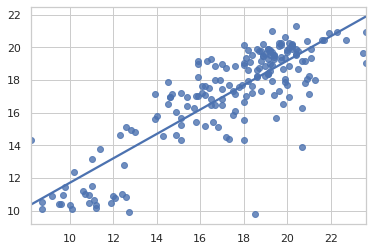

In [11]:
plot_x, plot_y = list(), list()

ho_pheno = ho_pheno.ravel()

for counter, i in enumerate(ho_pheno):
    if counter <= 5:
        print(counter, i, all_preds[counter])
    #zoom in a bit closer
    if(all_preds[counter] > 9):
        plot_x.append(i)
        plot_y.append(all_preds[counter])
    
#plt.plot(plot_x, plot_y, '.')
thisplot = pd.DataFrame({'Oil':plot_x, 'preds':plot_y})
#sns.jointplot(x="Oil", y="preds", data=thisplot, kind='reg' , joint_kws={'scatter_kws': {'alpha': 0.2}})
sns.regplot(x="Oil", y="preds", data=thisplot)
plt.xlabel('Real Seed Oil %')
plt.ylabel('Predicted Seed Oil %')
plt.title("DNN Seed Oil Prediction")
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=100, facecolor='w', edgecolor='k')
x_ax = range(len(ho_pheno))
print(x_ax)
plt.plot(x_ax, ho_pheno, label="Actual %")
plt.plot(x_ax, all_preds, label="Predicted %") 

plt.title("Seed Oil % Predicted vs Actual")
plt.xlabel('Validation Sample')
plt.ylabel('Seed Oil Percentage')

plt.legend()
plt.show()

In [ ]:
pickle.dump(best_DNN, open("Oil_kfold_10_DNN.pickle.dat", "wb"))

In [ ]:
best_DNN = pickle.load(open("Oil_kfold_10_DNN.pickle.dat", "rb"))

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

range(0, 189)


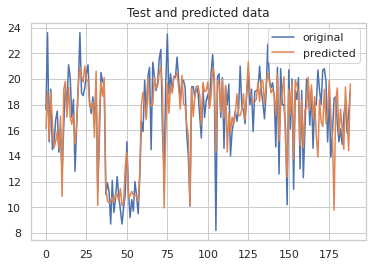

TypeError: list indices must be integers or slices, not range

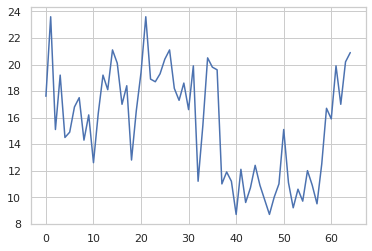

In [10]:
y_test=ho_pheno
x_ax = range(len(y_test))
print(x_ax)
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, all_preds, label="predicted") 

plt.title("Test and predicted data")

plt.legend()
plt.show()

i = 0
interval = 65
while(i<len(y_test)):
    i = i + interval
    if(i>len(y_test)):
        my_range = range(i-interval,len(y_test))
    else:
        my_range = range(i-interval,i)
    plt.plot(my_range, y_test[my_range], label="original")
    plt.plot(my_range, all_preds[my_range], label="predicted") 

    plt.title("Test and predicted data")

    plt.legend()
    plt.show()

In [ ]:
d = {'targs': [x for x in pheno], 'preds': [x[0] for x in model.predict(vcf)]}

testdf = pd.DataFrame(data=d)
testdf['minus'] = testdf['targs'] - testdf['preds']

In [ ]:
ss = sqrt(mean_squared_error(testdf["preds"], testdf['targs']))
mm = np.mean(pheno)
print("RMSE for dataset is:" +str(ss) + "& pheno is " + str(mm))
print("this is "+ str((ss/mm)*100) + "% of the mean pheno data")